## Import libraris

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append('../')
from utilities.ML_algorithms import create_RF_model, create_XGB_model, create_ANN_model
from utilities.plot_results import plot_prediction, plot_scores, plot_feature_importance

## Read data train

In [2]:
cs_file = '../data/SMB_input_four_ERA5.csv'

df_train = pd.read_csv(cs_file, delimiter='\t', index_col=['Date'], parse_dates=['Date'], na_values='NAN')


## Relabel stakes

In [3]:
df_train.reset_index(inplace=True)
df_train = df_train.sort_values(by = ['Elevation', 'Date'], ascending=True).reset_index()
df_train['Year'] = df_train['Date'].dt.year


In [4]:
label_stake = df_train.drop_duplicates(subset=['Elevation']).reset_index()[['Elevation', 'Stake']]
label_stake

,Elevation,Stake
0,96.8,PG19
1,121.0,PG09
2,131.4,PG18
3,159.1,PG08
4,167.2,PG17
5,188.6,PG07
6,194.5,PG16_AWS
7,223.7,PG06
8,229.4,PG16
9,247.9,PG05


In [5]:
label_stake_mod = label_stake.copy()
label_stake_mod.index = label_stake_mod['Elevation']
range_elev = np.arange(90,470, 30)
range_elev[-1]  = range_elev[-1] + 30
range_elev1 =range_elev[0:8]
range_elev1[-1] = range_elev[-1]
range_elev1

array([ 90, 120, 150, 180, 210, 240, 270, 480])

In [6]:
grupos_ele = []
for i in range(len(range_elev1)-1):
    print(i)
    grupos_ele.append(label_stake_mod.loc[range_elev1[i]:range_elev1[i+1]])

0
1
2
3
4
5
6


In [7]:
for i in range(len(grupos_ele)):
    df_train['Stake'].replace(grupos_ele[i]['Stake'].values.tolist(), 'G'+str(i), inplace = True)

In [8]:
#print(df_train)

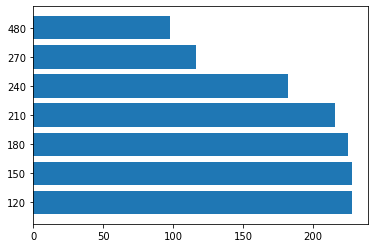

In [9]:
fig, ax = plt.subplots()
ax.barh(np.arange(len(range_elev1)-1), df_train['Stake'].value_counts().values)
ax.set_yticks(np.arange(len(range_elev1)-1))
ax.set_yticklabels(range_elev1[1:])
print()

In [10]:
label_year = df_train.drop_duplicates(subset=['Year']).reset_index()[['Year']]
label_year

,Year
0,2010
1,2011
2,2012
3,2013
4,2014
5,2015
6,2016


In [11]:
label_stake = df_train.drop_duplicates(subset=['Stake']).reset_index(drop=True)[['Stake']]
label_stake

,Stake
0,G0
1,G1
2,G2
3,G3
4,G4
5,G5
6,G6


## Folds to train

In [12]:
n_folds = 7

prng = np.random.RandomState(1)
index_year = prng.randint(0, len(label_year), n_folds) # Random year indexes
print(index_year)

prng = np.random.RandomState(1)
random_stake1 = prng.randint(0, len(label_stake), n_folds) # Random glacier indexes
prng = np.random.RandomState(2021)
random_stake2 = prng.randint(0, len(label_stake), n_folds) # Random glacier indexes

index_stake = np.stack((random_stake1, random_stake2), axis=1)
print(index_stake)

[5 3 4 0 1 3 5]
[[5 4]
 [3 5]
 [4 1]
 [0 0]
 [1 5]
 [3 6]
 [5 6]]


### Create matrix of indexes

In [13]:
custom_cv = []
for i in range(len(index_stake)):
    
    label_stake_fold = (label_stake.loc[index_stake[i]]['Stake'].values)
    label_year_fold = (label_year.loc[[index_year[i]]]['Year'].values)

    test_idx = df_train[['Stake', 'Year']].isin({'Stake':label_stake_fold, 'Year':label_year_fold})
    data_test_index = test_idx[(test_idx['Year'] == True) | (test_idx['Stake'] == True)].index
    
    df_train_copy =  df_train.copy()
    data_train_index = df_train_copy.drop(data_test_index, axis=0).index
    
    custom_cv.append((np.array(data_train_index), np.array(data_test_index)))

In [14]:
len(custom_cv)

7

## Read data test

In [15]:
cs_file = '../data/SMB_input_belli_ERA5.csv'
df_test = pd.read_csv(cs_file, delimiter='\t', index_col=['Date'], parse_dates=['Date'], na_values='NAN')
features_to_drop = ['Stake', 'Latitude','Longitude', 'SMB']
X_test = (df_test.drop(features_to_drop, axis=1)).to_numpy()
y_test = (df_test['SMB'].copy()).to_numpy()

## Convert train dataframe to array

In [16]:
features_to_drop = ['index','Date', 'Stake', 'Latitude','Longitude', 'SMB', 'Year']

df_train_X = (df_train.drop(features_to_drop, axis=1)) 
X = (df_train.drop(features_to_drop, axis=1)).to_numpy()
y = (df_train['SMB'].copy()).to_numpy()


## Lasso train

In [17]:
cv_model_lasso = LassoCV(cv=custom_cv).fit(X, y)
cv_model_lasso

/home/christian/miniconda3/envs/DL_SMB/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.049625302133676996, tolerance: 0.0071114579293544465
  model = cd_fast.enet_coordinate_descent_gram(


LassoCV(cv=[(array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
         88,   89,   90,  110,  111,  112,  113,  114,  115,  116,  117,
        118,  119,  120,  121,  122,  123,  124,  125,  126...
       1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229,
       1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240,
       1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251,
       1252, 1253, 1254, 1255, 1256, 1257, 1258,

### Evaluation Lasso with glaciar test data (Bellin)

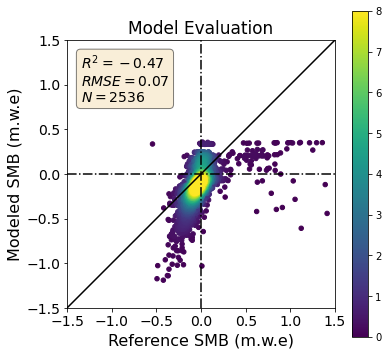

In [18]:
fig = plot_prediction(y_test, cv_model_lasso.predict(X_test), len(y_test), n_toplot=5000 )

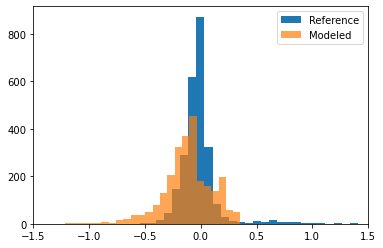

In [19]:
plt.hist(y_test, bins=50, label='Reference')
plt.hist(cv_model_lasso.predict(X_test), bins=50, alpha=0.7,  label='Modeled')
plt.xlim(-1.5, 1.5)
plt.legend()

## RF train

In [20]:
RF_model = create_RF_model(custom_cv).fit(X, y)

In [21]:
RF_model.best_params_

{'n_estimators': 300, 'min_samples_leaf': 5, 'max_features': 3, 'max_depth': 8}

### Evaluation RF with glaciar test data (Bellin)

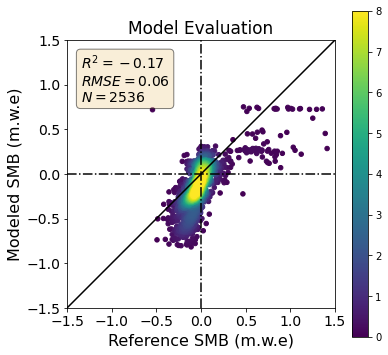

In [22]:
fig = plot_prediction(y_test, RF_model.predict(X_test), len(y_test), n_toplot=5000 )

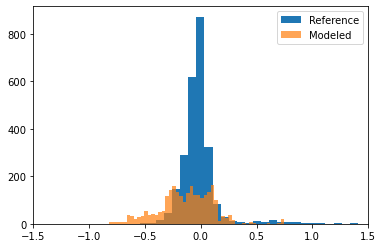

In [23]:
plt.hist(y_test, bins=50, label='Reference')
plt.hist(RF_model.predict(X_test), bins=50, alpha=0.7,  label='Modeled')
plt.xlim(-1.5, 1.5)
plt.legend()

<Figure size 432x216 with 0 Axes>

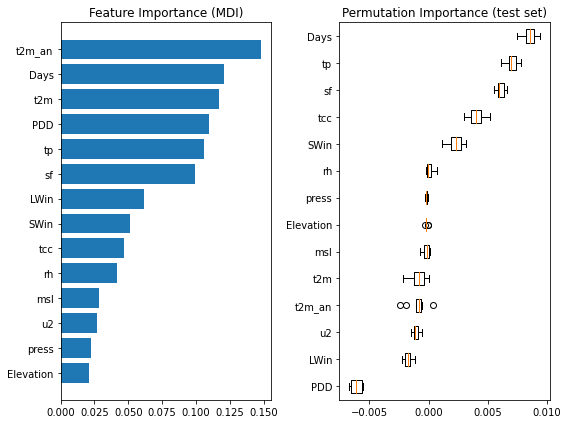

In [24]:
fig = plot_feature_importance(RF_model, df_train_X, X_test, y_test)

## XGBoot train

In [25]:
XGB_model = create_XGB_model(custom_cv).fit(X, y)

In [26]:
XGB_model.best_params_

{'n_estimators': 500,
 'min_samples_leaf': 20,
 'max_features': 4,
 'max_depth': 4}

### Evaluation XGBoot with glaciar test data (Bellin)

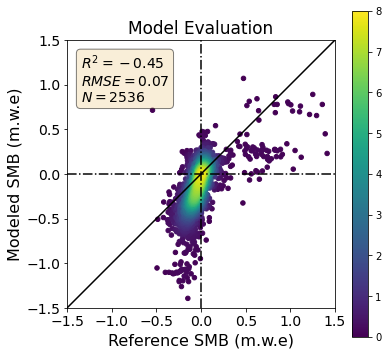

In [27]:
fig = plot_prediction(y_test, XGB_model.predict(X_test), len(y_test), n_toplot=5000 )

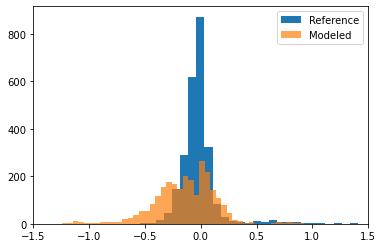

In [28]:
plt.hist(y_test, bins=50, label='Reference')
plt.hist(XGB_model.predict(X_test), bins=50, alpha=0.7,  label='Modeled')
plt.xlim(-1.5, 1.5)
plt.legend()

<Figure size 432x216 with 0 Axes>

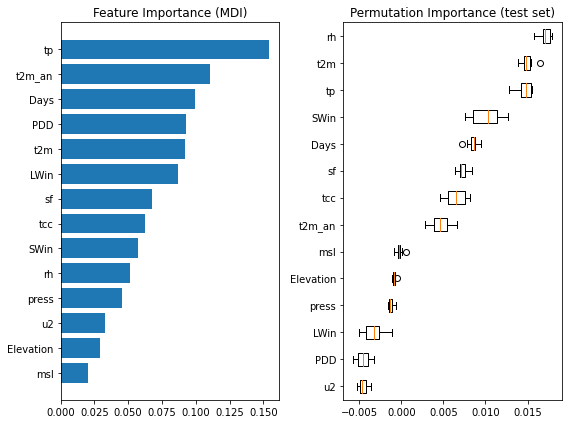

In [29]:
fig = plot_feature_importance(XGB_model, df_train_X, X_test, y_test)

## Train ANNs

In [30]:
scaler = StandardScaler().fit(X)
ANN_model = create_ANN_model(custom_cv).fit(scaler.transform(X), y)

/home/christian/miniconda3/envs/DL_SMB/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/christian/miniconda3/envs/DL_SMB/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/christian/miniconda3/envs/DL_SMB/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: Conv

In [31]:
ANN_model.best_params_

{'validation_fraction': 0.001,
 'solver': 'adam',
 'shuffle': False,
 'max_iter': 200,
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': 50,
 'batch_size': 50,
 'alpha': 5e-05,
 'activation': 'tanh'}

### Evaluation ANN with glaciar test data (Bellin)

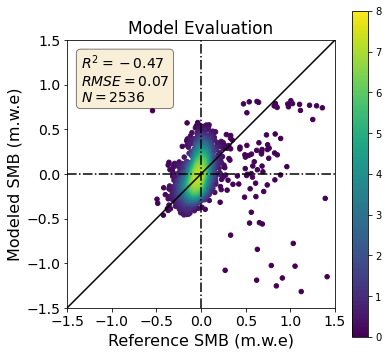

In [32]:
fig = plot_prediction(y_test, ANN_model.predict(scaler.transform(X_test)), len(y_test), n_toplot=5000)

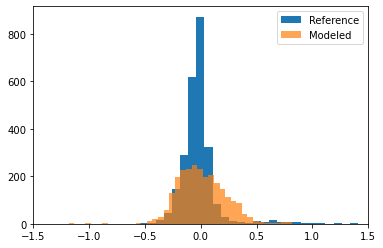

In [33]:
plt.hist(y_test, bins=50, label='Reference')
plt.hist(ANN_model.predict(scaler.transform(X_test)), bins=50, alpha=0.7,  label='Modeled')
plt.xlim(-1.5, 1.5)
plt.legend()

In [34]:
#plot_feature_importance(MLP_gridCV, df_train_X, X_test, y_test)
#print()